In [1]:
# Gerekli kütüphaneleri yükleme
#Bu paketler, finansal veri analizi, makine öğrenimi modelleri oluşturma ve veri görselleştirme gibi çeşitli görevler için kullanılır.
!pip install yfinance quandl tensorflow keras matplotlib seaborn scikit-learn statsmodels


In [2]:
# Bu kütüphaneler, finansal veri analizi, veri işleme, veri görselleştirme, makine öğrenimi, derin öğrenme ve zaman serisi analizi için kullanılıyor.
import yfinance as yf
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Quandl API anahtarı
#Bu satır, Quandl API'sini kullanarak veri çekebilmek için API anahtarınızı yapılandırır. Quandl, API anahtarı olmadan veri çekmenize izin vermez.
#API anahtarı, sizin Quandl hesabınıza özel bir kimlik bilgisi gibidir ve API çağrılarınızın kimden geldiğini belirler.
quandl.ApiConfig.api_key = 'hVb6xtSUyvWmNpn7ztqf'


In [13]:
#Bu kodlar genel olarak Yahoo Finance ve Quandl'dan hisse senedi verilerini çekiyor, bu verileri birleştiriyor, işliyor ve makine öğrenimi modelleri (özellikle LSTM) için hazırlıyor.

# Yahoo Finance'den veri çekme
ticker = 'MRVL'
data_yf = yf.download(ticker, start='2023-05-06', end='2024-06-06')
#Yahoo Finance'den Apple Inc. (AAPL) hisse senedi fiyatlarını 2020-01-01'den 2024-07-06'e kadar çekiyor.


# Quandl'dan veri çekme
data_quandl = quandl.get("WIKI/MRVL", start_date="2023-05-06", end_date="2024-06-06")
#Quandl'dan aynı dönemde Apple Inc. (AAPL) hisse senedi fiyatlarını çekiyor.


# Verileri birleştirme
data_yf.reset_index(inplace=True)
data_quandl.reset_index(inplace=True)
#Her iki veri kümesinin indekslerini sıfırlıyor.
# İlgili sütunları seçme ve yeniden adlandırma
data_quandl = data_quandl[['Date', 'Adj. Close']]
data_quandl.columns = ['Date', 'Adj_Close_quandl']
# İlgili sütunları seçme
data_yf.columns = ['Date'] + list(data_yf.columns[1:])
#Quandl verilerinde sadece Date ve Adj. Close sütunlarını alıyor ve Adj_Close_quandl olarak yeniden adlandırıyor.
#Yahoo Finance verilerinde tarih sütunu Date olarak bırakıp diğer sütunları olduğu gibi koruyor.


# Verileri birleştirme
data = pd.merge(data_yf, data_quandl, on='Date', how='outer')
# Tarihleri indeks olarak ayarlama
data.set_index('Date', inplace=True)
# NaN değerleri temizleme - Fill missing values (if any) after the outer join
data.fillna(method='ffill', inplace=True)  # Forward fill missing values
#Date sütunu üzerinde birleştiriyor (outer join kullanarak tüm tarihleri tutuyor).
#Eksik değerleri ileri doldurma (forward fill) yöntemiyle dolduruyor.



if data.isnull().values.any():
    print("Warning: There are still missing values in the dataset.")
    data.fillna(0, inplace=True)
#Eğer hala eksik değerler varsa, bunları 0 ile dolduruyor.



if 'Close' in data.columns:
    # Özellikleri ve hedef değişkeni ayırma
    X = data.drop(['Close'], axis=1)
    y = data['Close']
else:
    print("Error: 'Close' column not found in the dataset. Check your data sources.")
#Close sütununu hedef değişken olarak ayırıyor, geri kalan tüm sütunları özellikler olarak ayırıyor.

# Verilerin ölçeklendirilmesi
scaler_X = StandardScaler()
if X.shape[0] > 0:
    X_scaled = scaler_X.fit_transform(X)
else:
    print("Error: X is an empty DataFrame. Cannot perform scaling.")
# Hedef değişkeni (Close fiyatları) ölçeklendirme
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
#Özellikleri ve hedef değişkeni ölçeklendiriyor (StandardScaler kullanarak).


# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
#Verileri eğitim ve test setlerine ayırıyor (test seti %20).


# Verileri 3D hale getirme (LSTM için)
X_train_lstm = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#LSTM modeli için verileri 3 boyutlu hale getiriyor

[*********************100%%**********************]  1 of 1 completed


In [14]:
#Bu kod parçacığı LSTM (Long Short-Term Memory) modelini oluşturur, eğitir ve test seti üzerinde tahminler yaparak modeli değerlendirir.

# LSTM Modeli
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(50, return_sequences=False))
model_lstm.add(Dense(25))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

model_lstm.fit(X_train_lstm, y_train, batch_size=20, epochs=70)

# Tahmin
predictions_lstm_scaled = model_lstm.predict(X_test_lstm)
predictions_lstm = scaler_y.inverse_transform(predictions_lstm_scaled)

# Değerlendirme
rmse_lstm = np.sqrt(np.mean((predictions_lstm - scaler_y.inverse_transform(y_test))**2))
print('LSTM RMSE:', rmse_lstm)

#Bu kod parçası, bir LSTM modeli tanımlar ve derin öğrenme modelini zaman serisi verilerini (örneğin, hisse senedi fiyatları gibi) analiz etmek ve tahmin etmek için kullanılabilir hale getirir.
#Model, ardışık veri yapılarında uzun ve kısa vadeli bağımlılıkları öğrenebilir ve bu bağımlılıkları kullanarak gelecekteki değerleri tahmin edebilir.


Epoch 1/70
11/11 [==============================] - 6s 8ms/step - loss: 0.6381
Epoch 2/70
11/11 [==============================] - 0s 9ms/step - loss: 0.1165
Epoch 3/70
11/11 [==============================] - 0s 8ms/step - loss: 0.0738
Epoch 4/70
11/11 [==============================] - 0s 9ms/step - loss: 0.0466
Epoch 5/70
11/11 [==============================] - 0s 8ms/step - loss: 0.0313
Epoch 6/70
11/11 [==============================] - 0s 9ms/step - loss: 0.0298
Epoch 7/70
11/11 [==============================] - 0s 9ms/step - loss: 0.0280
Epoch 8/70
11/11 [==============================] - 0s 8ms/step - loss: 0.0276
Epoch 9/70
11/11 [==============================] - 0s 8ms/step - loss: 0.0279
Epoch 10/70
11/11 [==============================] - 0s 8ms/step - loss: 0.0276
Epoch 11/70
11/11 [==============================] - 0s 8ms/step - loss: 0.0251
Epoch 12/70
11/11 [==============================] - 0s 8ms/step - loss: 0.0245
Epoch 13/70
11/11 [==============================

In [15]:
# Random Forests Modeli
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train.ravel())

# Tahmin
predictions_rf = model_rf.predict(X_test)

# Değerlendirme
rmse_rf = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(predictions_rf.reshape(-1, 1))))
print('Random Forest RMSE:', rmse_rf)

#Bu kod parçacığı, Random Forest regresyon modelini kullanarak verileri tahmin etmek için bir makine öğrenimi yaklaşımı sunar ve modelin performansını ölçmek için RMSE gibi bir değerlendirme metriği kullanır.

Random Forest RMSE: 0.9784526764655302


In [16]:
# ARIMA Modeli
model_arima = ARIMA(scaler_y.inverse_transform(y_train).ravel(), order=(5, 1, 0))
model_arima_fit = model_arima.fit()

# Tahmin
predictions_arima = model_arima_fit.forecast(steps=len(y_test))

# Değerlendirme
rmse_arima = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_test), predictions_arima))
print('ARIMA RMSE:', rmse_arima)
#Bu kod parçacığı, ARIMA modelini kullanarak verileri tahmin etmek için bir zaman serisi analizi yaklaşımı sunar ve modelin performansını ölçmek için RMSE gibi bir değerlendirme metriği kullanır.

ARIMA RMSE: 9.579928165230552


2/2 [==============================] - 0s 11ms/step


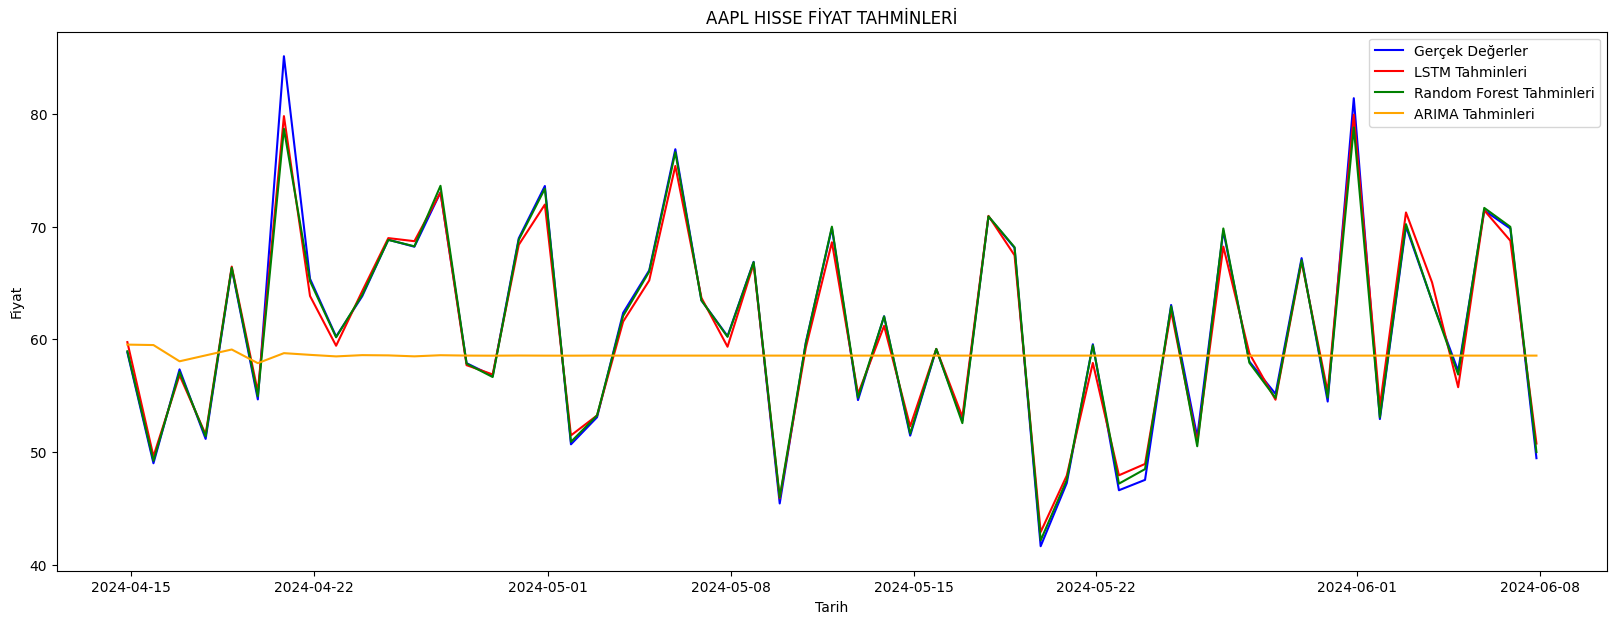

In [17]:
# Güncel Tarih Aralığını Oluşturma
current_dates = pd.date_range(end=pd.to_datetime('today'), periods=len(y_test))

# Güncel Tahminlerin Yapılması
updated_predictions_lstm = model_lstm.predict(X_test_lstm)
updated_predictions_rf = model_rf.predict(X_test)
updated_predictions_arima = model_arima_fit.forecast(steps=len(y_test))

# Sonuçların Görselleştirilmesi
plt.figure(figsize=(20, 7))

plt.plot(current_dates, scaler_y.inverse_transform(y_test), color='blue', label='Gerçek Değerler')
plt.plot(current_dates, predictions_lstm, color='red', label='LSTM Tahminleri')
plt.plot(current_dates, scaler_y.inverse_transform(updated_predictions_rf.reshape(-1, 1)), color='green', label='Random Forest Tahminleri')
plt.plot(current_dates, predictions_arima, color='orange', label='ARIMA Tahminleri')

plt.title('AAPL HISSE FİYAT TAHMİNLERİ')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.legend()
plt.show()